In [1]:
import json
from pathlib import Path

In [2]:
# Importing the dataset.
# The LIDAR server produces samples at 30Hz with object positions normalized in their
# space, i.e. x and y values are in the 0-1 range.
datadir = Path("../testdata")
names = [
    "dump-1731964073793.jsonl",
    "dump-1731965089198.jsonl",
    "dump-1731966752296.jsonl"
]

dataset = []
for name in names:
    path = datadir.joinpath(datadir, name)
    f = open(path, 'r')
    last_is_zero = False
    for line in f.readlines():
        d = json.loads(line)
        if d['type'] != 'object':
            continue
        payload = d['payload']
        # At the beginning and end of the session there is nobody on stage and
        # there are many 0,0 points.
        is_zero = payload['x'] == 0 and payload['y'] == 0
        if is_zero:
            continue
            
        dataset.append({
            'x': payload['x'],
            'y': payload['y'],
        })

In [28]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

class PointSequenceDataset(Dataset):
    def __init__(self, data, sequence_length=10):
        self.sequence_length = sequence_length
        
        # Convert data from list of dicts to numpy arrays
        xy_points = np.array([[d['x'], d['y']] for d in data])
        
        # Create sequences
        self.sequences = []
        self.targets = []
        
        for i in range(len(xy_points) - sequence_length):
            self.sequences.append(xy_points[i:i + sequence_length])
            self.targets.append(xy_points[i + sequence_length])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor(self.targets[idx])

class PointPredictor(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=2):
        super(PointPredictor, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.linear = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

def train_model(data, epochs=100, sequence_length=10, batch_size=32):
    # Create dataset and dataloader
    dataset = PointSequenceDataset(data, sequence_length=sequence_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer
    model = PointPredictor()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for sequences, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.6f}')
    
    return model

def predict_next_point(model, sequence):
    model.eval()
    with torch.no_grad():
        # Convert input sequence to tensor
        sequence_tensor = torch.FloatTensor(sequence).unsqueeze(0)  # Add batch dimension
        prediction = model(sequence_tensor)
        return {'x': prediction[0][0].item(), 'y': prediction[0][1].item()}

In [24]:
# Train the model
sequence_length = 30
trained_model = train_model(dataset, sequence_length=30, epochs=100)

Epoch [10/100], Loss: 0.000019
Epoch [20/100], Loss: 0.000010
Epoch [30/100], Loss: 0.000009
Epoch [40/100], Loss: 0.000008
Epoch [50/100], Loss: 0.000008
Epoch [60/100], Loss: 0.000008
Epoch [70/100], Loss: 0.000007
Epoch [80/100], Loss: 0.000008
Epoch [90/100], Loss: 0.000007
Epoch [100/100], Loss: 0.000007


In [26]:
# Let's generate a huge session starting from the last point of the dataset.
last = dataset[-1]

In [29]:
last['t'] = 0
generated = [last]

for i in range(1, 40000):
    seq = np.array([[d['x'], d['y']] for d in generated[-30:]])
    next = predict_next_point(trained_model, seq)
    next['t'] = i
    generated.append(next)

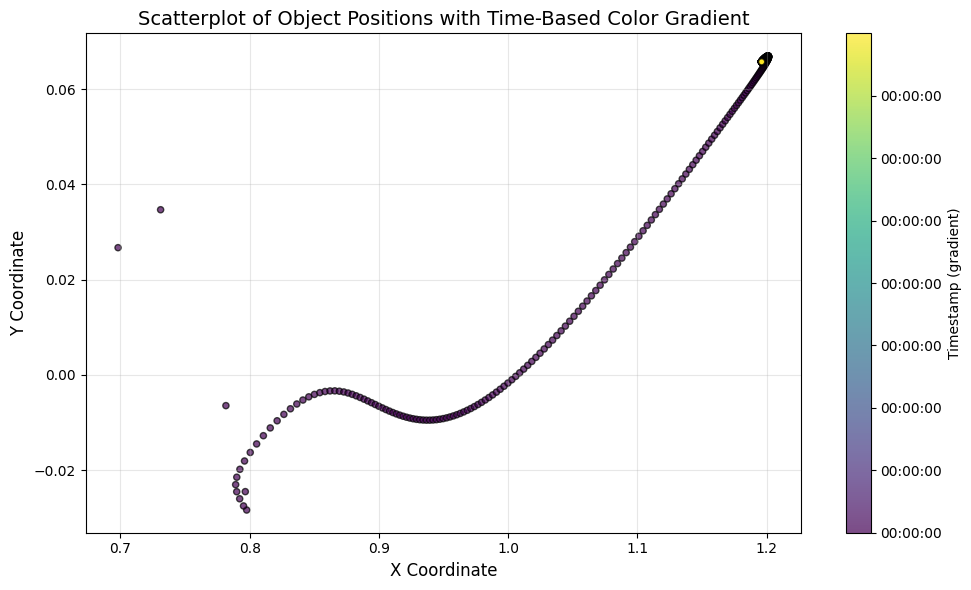

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

# Convert 'received_at' to datetime for gradient coloring
x, y, t = [], [], []
for d in generated:
    x.append(d['x'])
    y.append(d['y'])
    t.append(d['t'])

# Scatter plot with color gradient based on timestamps
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    x,
    y,
    c=t,
    cmap='viridis',
    s=20,
    edgecolor='k',
    alpha=0.7
)

# Add colorbar to indicate the time gradient
cbar = plt.colorbar(sc, label='Timestamp (gradient)')
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Plot formatting
plt.title('Scatterplot of Object Positions with Time-Based Color Gradient', fontsize=14)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()